In [1]:
!pip install torchvision
!pip install opencv-python
!pip install matplotlib
!pip install albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def load_image(path):
    img = Image.open(path).convert("RGB")
    return img

def preprocess(img, size=(256, 192)):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # (1, C, H, W)


In [3]:
def create_fake_mask(image_tensor):
    # Simulate a mask for demo purpose
    mask = torch.zeros_like(image_tensor)
    mask[:, :, 64:192, 32:160] = 1  # crude human-like body region
    return mask


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleWarpNet(nn.Module):
    def __init__(self):
        super(SimpleWarpNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, person, cloth):
        x = torch.cat([person, cloth], dim=1)
        return self.conv(x)


In [5]:
class TryOnSynthesizer(nn.Module):
    def __init__(self):
        super(TryOnSynthesizer, self).__init__()
        self.generator = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, person, warped_cloth):
        x = torch.cat([person, warped_cloth], dim=1)
        return self.generator(x)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
warp_net = SimpleWarpNet().cuda()
tryon_net = TryOnSynthesizer().cuda()
optimizer = torch.optim.Adam(list(warp_net.parameters()) + list(tryon_net.parameters()), lr=0.001)

for epoch in range(10):
    person_img = preprocess(load_image('/content/drive/MyDrive/Colab Notebooks/VTO2/person.png')).cuda()
    cloth_img = preprocess(load_image('/content/drive/MyDrive/Colab Notebooks/VTO2/cloth.png')).cuda()

    person_img = person_img.unsqueeze(0).cuda()
    cloth_img = cloth_img.unsqueeze(0).cuda()

    warped_cloth = warp_net(person_img, cloth_img)
    output = tryon_net(person_img, warped_cloth)

    loss = F.l1_loss(output, person_img)  # Simulated, use real target for real training
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch} Loss: {loss.item():.4f}")


Epoch 0 Loss: 0.7574
Epoch 1 Loss: 0.6781
Epoch 2 Loss: 0.5994
Epoch 3 Loss: 0.5143
Epoch 4 Loss: 0.4211
Epoch 5 Loss: 0.3259
Epoch 6 Loss: 0.2502
Epoch 7 Loss: 0.1855
Epoch 8 Loss: 0.1387
Epoch 9 Loss: 0.1190


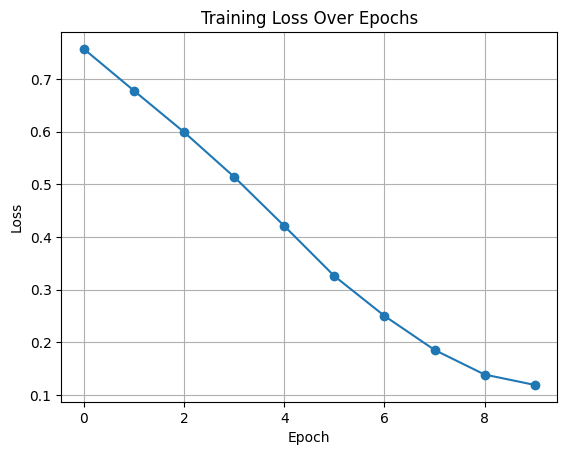

In [13]:
import matplotlib.pyplot as plt

loss_values = [0.7574, 0.6781, 0.5994, 0.5143, 0.4211, 0.3259, 0.2502, 0.1855, 0.1387, 0.1190]
plt.plot(loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [14]:
import torchvision.transforms as T

to_pil = T.ToPILImage()
result_image = output.squeeze(0).cpu().clamp(0, 1)
to_pil(result_image).save("tryon_result.png")
to_pil(result_image).show()


In [15]:
torch.save({
    'warp_net': warp_net.state_dict(),
    'tryon_net': tryon_net.state_dict()
}, 'virtual_tryon_model.pth')